In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('/workspace/deep_birth_death/src')

from evaluation.regression import get_regression_metrics, plot_errors_boxplot, plot_errors, predicted_minus_target_vs_target, get_clipping_results

## Generate the results

In [3]:
pd.options.display.float_format = "{:,.4f}".format

In [4]:
n_tips = [674, 489, 87]
div_scenarios = ["BD", "HE", "ME", "SAT", "SR", "WW"]

In [5]:
inference_results = dict()

for tip in n_tips:
    inference_results[tip] = dict()
    for div in div_scenarios:
        
        #Load the data
        inference_results[tip][div] = dict()

        file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/TreePar_inference_" + str(tip) + "_" + div + ".csv"
        if div == "SAT":
            file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/DDD_inference_" + str(tip) + "_" + div + ".csv"
        df = pd.read_csv(file_path)
        
        if div == "BD":
            y_test = df[["real_r0", "real_a0"]].to_numpy()
            y_pred_raw = df[["estimated_r", "estimated_a"]].to_numpy()
            
            min_value = np.array([0.01, 0.01])            
            max_value = np.array([4, 0.5])                        
            
        elif div == "HE":
            y_test = df[["real_r0", "real_a0"]].to_numpy()
            y_pred_raw = df[["estimated_r", "estimated_a"]].to_numpy()
            
            min_value = np.array([0.01, 0.8])            
            max_value = np.array([4, 0.9])   
                        
        elif div == "SAT":
            y_test = df[["real_lambda"]].to_numpy()
            y_pred_raw = df[["estimated_lambda"]].to_numpy()
            
            min_value = np.array([0.01])            
            max_value = np.array([4])  
  
            
        elif div == "ME":
            y_test = df[["real_r0", "real_a0", "real_t", "real_frac_1"]].to_numpy()
            y_pred_raw = df[["estimated_r_me", "estimated_a_me", "estimated_time_me", "estimated_frac_1_me"]].to_numpy()
          
            min_value = np.array([0.01, 0.3, 3, 0.1])            
            max_value = np.array([1, 0.8, 20, 0.3]) 
        
        elif div == "SR":
            y_test = df[["real_r0", "real_r1", "real_a0", "real_a1", "real_t"]].to_numpy()
            y_pred_raw = df[["estimated_r0", "estimated_r1", "estimated_a0", "estimated_a1", "estimated_t"]].to_numpy()
        
            min_value = np.array([0.25, 0.01, 0.05, 0.55, 3])            
            max_value = np.array([1.99, 1, 0.5, 0.95, 20])         
        
        else: 
            y_test = df[["real_r0", "real_r1", "real_a0", "real_a1", "real_t"]].to_numpy()
            y_pred_raw = df[["estimated_r0", "estimated_r1", "estimated_a0", "estimated_a1", "estimated_t"]].to_numpy()
            
            min_value = np.array([-0.2, 0.5, 1.3, 0.25, 3])            
            max_value = np.array([-0.01, 1.5, 2, 0.6, 20])              
      
        
        #Clip the values
        y_pred = np.clip(y_pred_raw, min_value, max_value)
        precentage_clipped = (np.sum(y_pred_raw != y_pred, axis=0)/y_pred_raw.shape[0])*100
        
        clipped_below = (np.sum(y_pred_raw < min_value, axis=0) / y_pred_raw.shape[0]) * 100
        clipped_above = (np.sum(y_pred_raw > max_value, axis=0) / y_pred_raw.shape[0]) * 100

            
        #Estimate the erros
        mae = np.mean(np.abs(y_pred - y_test), axis=0)
        mre = np.mean(np.abs((y_pred - y_test) / y_test), axis=0)
        
        raw_error = y_pred - y_test
        abs_error = abs(y_pred - y_test)
        
        #Save the results
        inference_results[tip][div]["MAE"] = mae
        inference_results[tip][div]["MRE"] = mre       
        inference_results[tip][div]["raw_error"] = raw_error
        inference_results[tip][div]["abs_error"] = abs_error   
        
        inference_results[tip][div]["clipped_perc"] = precentage_clipped
        inference_results[tip][div]["clipped_below"] = clipped_below        
        inference_results[tip][div]["clipped_above"] = clipped_above   
        
        inference_results[tip][div]["real_values"] = y_test  

## Get regression metrics

### MAE 

In [6]:
for tip in n_tips: 
    print("----------- Size is " + str(tip) + " -----------\n")
    for scenario in div_scenarios: 
        print("-----------Div_scenario is " + scenario +" -----------")
        mae = get_regression_metrics(inference_results, tip, scenario, "MAE")
        print(mae, "\n")

----------- Size is 674 -----------

-----------Div_scenario is BD -----------
         r      a
MAE 0.1166 0.0688 

-----------Div_scenario is HE -----------
         r      a
MAE 0.2462 0.0191 

-----------Div_scenario is ME -----------
         r      a   time   frac
MAE 0.0338 0.0574 0.9089 0.0584 

-----------Div_scenario is SAT -----------
     lambda 0
MAE    0.0631 

-----------Div_scenario is SR -----------
        r0     r1     a0     a1   time
MAE 0.0579 0.0375 0.0899 0.1693 1.2234 

-----------Div_scenario is WW -----------
        r0     r1     a0     a1   time
MAE 0.0351 0.1407 0.2117 0.1621 0.3356 

----------- Size is 489 -----------

-----------Div_scenario is BD -----------
         r      a
MAE 0.1510 0.0805 

-----------Div_scenario is HE -----------
         r      a
MAE 0.2678 0.0260 

-----------Div_scenario is ME -----------
         r      a   time   frac
MAE 0.0264 0.0580 0.7131 0.0543 

-----------Div_scenario is SAT -----------
     lambda 0
MAE    0.0700 



### MRE 

In [7]:
for tip in n_tips: 
    print("----------- Size is " + str(tip) + " -----------\n")
    for scenario in div_scenarios: 
        print("-----------Div_scenario is " + scenario +" -----------")
        mre = get_regression_metrics(inference_results, tip, scenario, "MRE")
        print(mre, "\n")

----------- Size is 674 -----------

-----------Div_scenario is BD -----------
         r      a
MRE 0.0583 0.4991 

-----------Div_scenario is HE -----------
         r      a
MRE 0.1247 0.0225 

-----------Div_scenario is ME -----------
         r      a   time   frac
MRE 0.1016 0.1251 0.0936 0.2870 

-----------Div_scenario is SAT -----------
     lambda 0
MRE    0.0343 

-----------Div_scenario is SR -----------
        r0     r1     a0     a1   time
MRE 0.0894 0.6861 0.4115 0.2414 0.1742 

-----------Div_scenario is WW -----------
        r0     r1     a0     a1   time
MRE 0.4966 0.1417 0.1220 0.3624 0.0281 

----------- Size is 489 -----------

-----------Div_scenario is BD -----------
         r      a
MRE 0.0745 0.7354 

-----------Div_scenario is HE -----------
         r      a
MRE 0.1648 0.0308 

-----------Div_scenario is ME -----------
         r      a   time   frac
MRE 0.0905 0.1224 0.0776 0.2582 

-----------Div_scenario is SAT -----------
     lambda 0
MRE    0.0341 



### Clipping percentage

In [8]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for div in div_scenarios:
        print(f"--- {div} ---")
        df_tot, df_below, df_above = get_clipping_results(inference_results, tip, div)
        print(df_tot)
        print(df_below)
        print(df_above, "\n")


----------- Size is 674 -----------
--- BD ---
               r       a
Clipped % 1.0000 17.0000
             r      a
Below % 0.0000 9.0000
             r      a
Above % 1.0000 8.0000 

--- HE ---
               r       a
Clipped % 5.0000 21.0000
             r      a
Below % 0.0000 7.0000
             r       a
Above % 5.0000 14.0000 

--- ME ---
               r       a   time    frac
Clipped % 0.0000 16.0000 5.0000 30.0000
             r       a   time    frac
Below % 0.0000 13.0000 2.0000 24.0000
             r      a   time   frac
Above % 0.0000 3.0000 3.0000 6.0000 

--- SAT ---
           lambda 0
Clipped %    3.0000
         lambda 0
Below %    1.0000
         lambda 0
Above %    2.0000 

--- SR ---
              r0      r1      a0      a1   time
Clipped % 3.0000 38.0000 23.0000 68.0000 8.0000
            r0      r1      a0      a1   time
Below % 3.0000 38.0000 11.0000 30.0000 8.0000
            r0     r1      a0      a1   time
Above % 0.0000 0.0000 12.0000 38.0000 0.0000 

-

### Errors boxplots 


----------- Size is 674 -----------


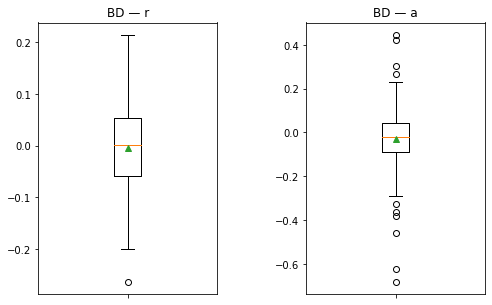

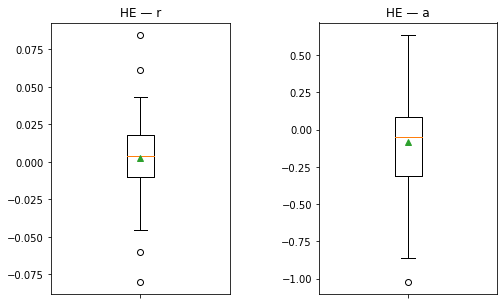

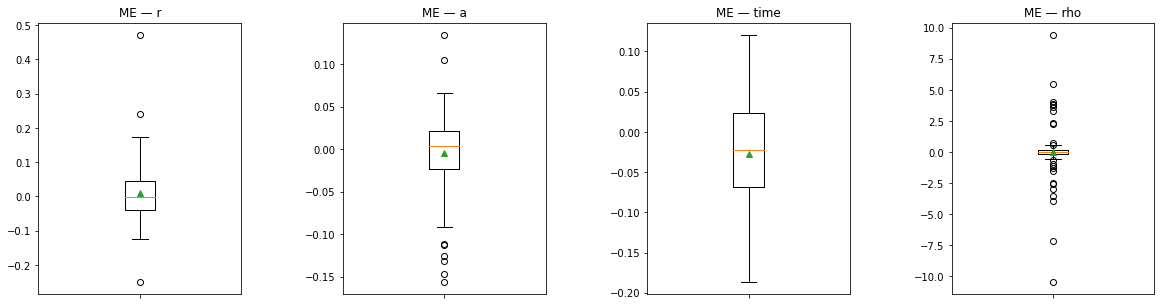

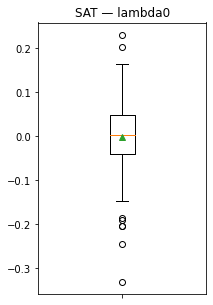

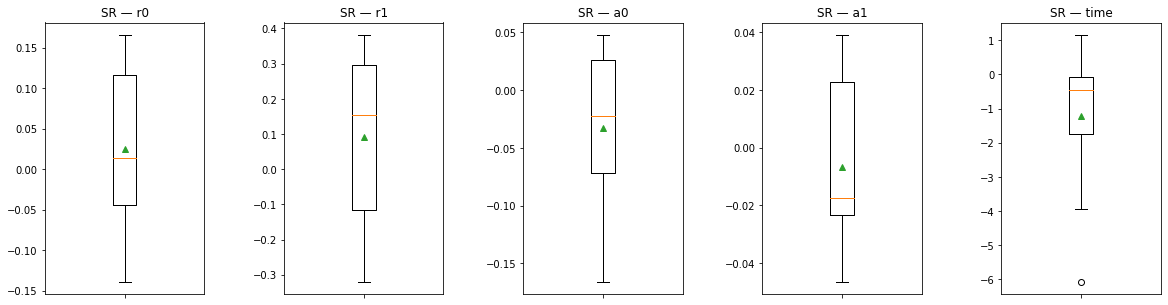

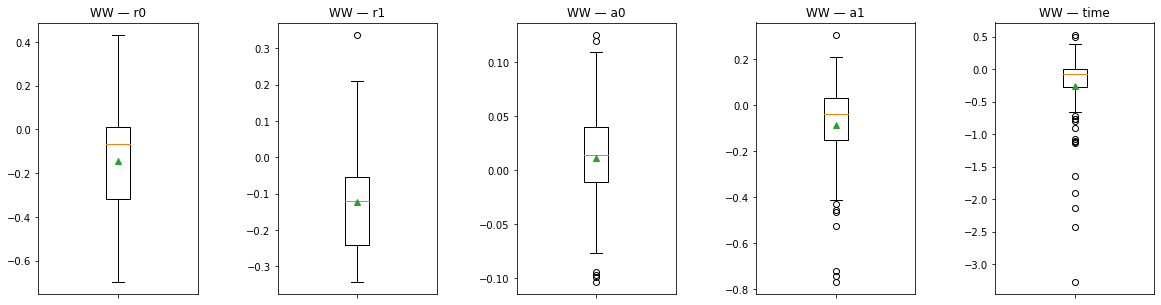


----------- Size is 489 -----------


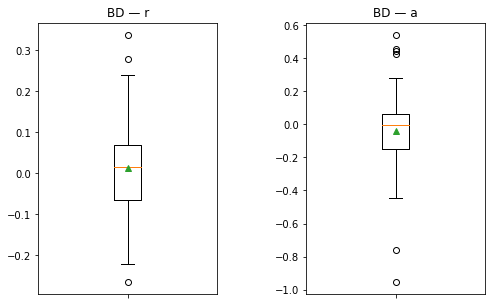

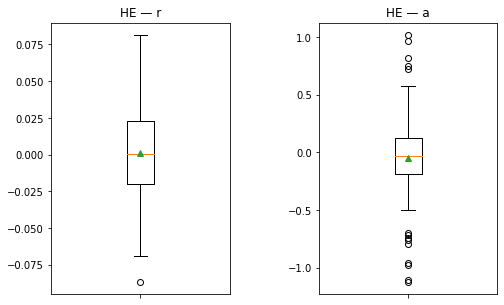

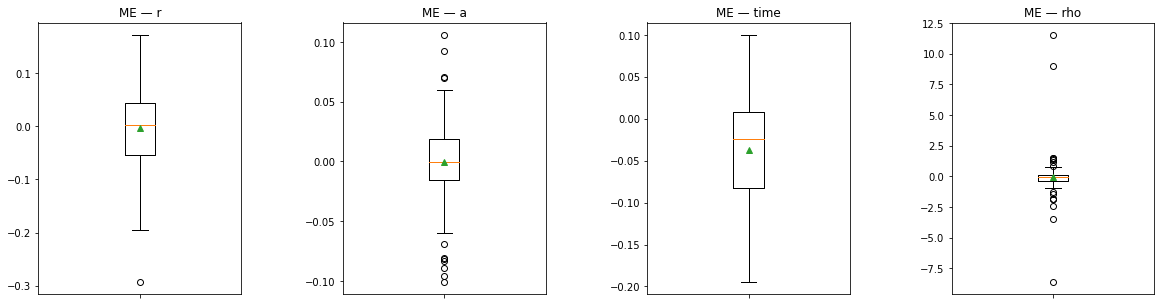

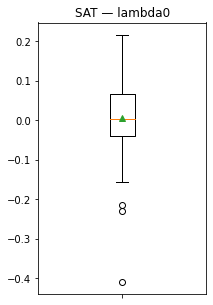

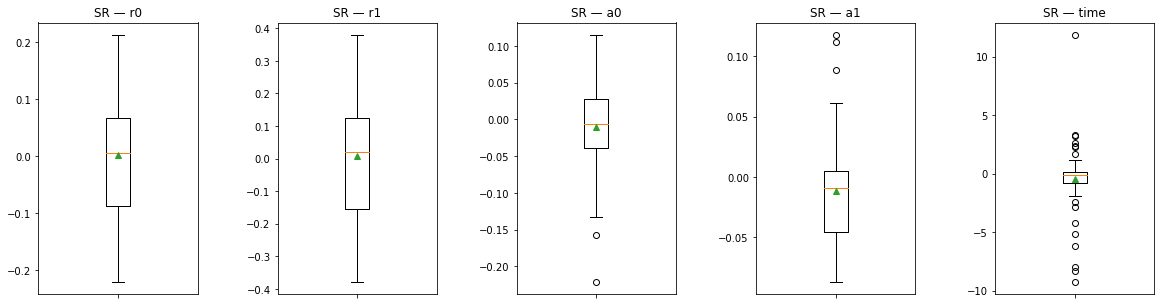

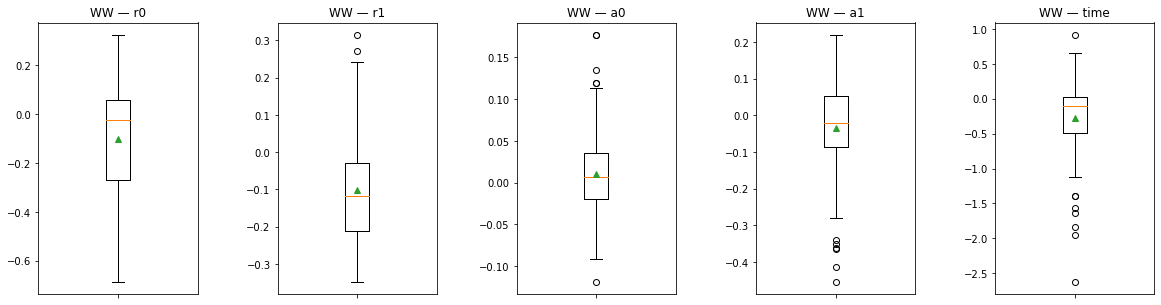


----------- Size is 87 -----------


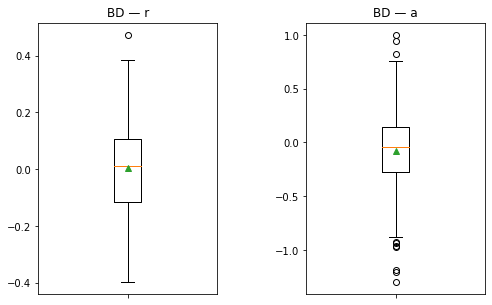

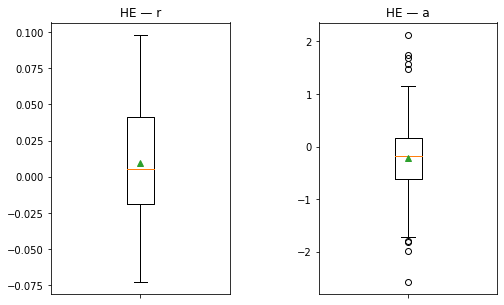

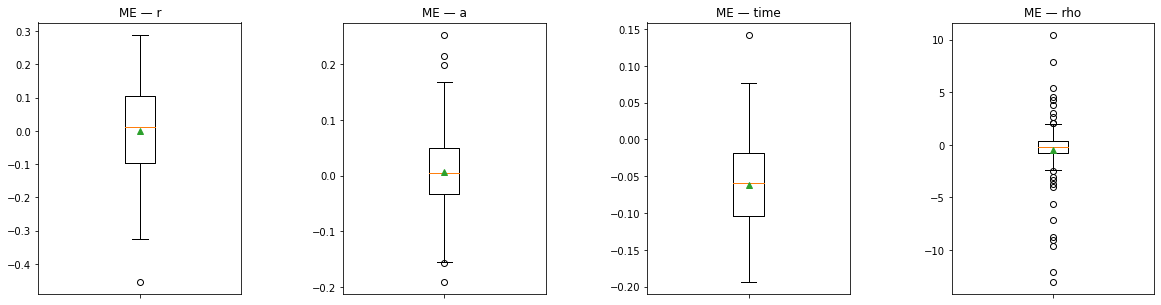

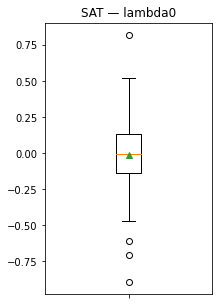

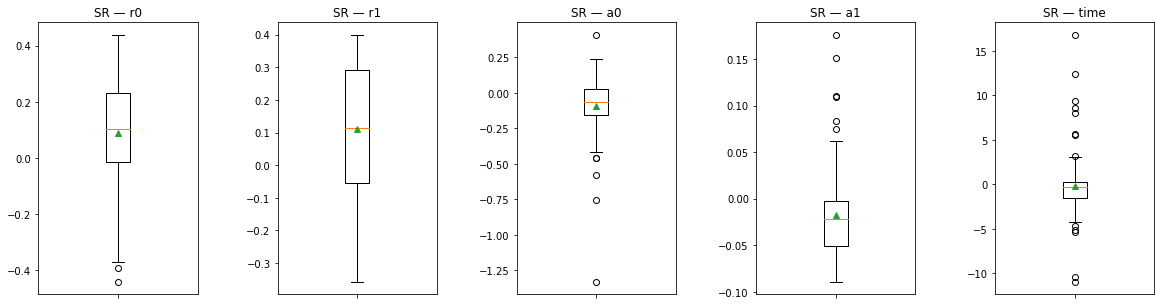

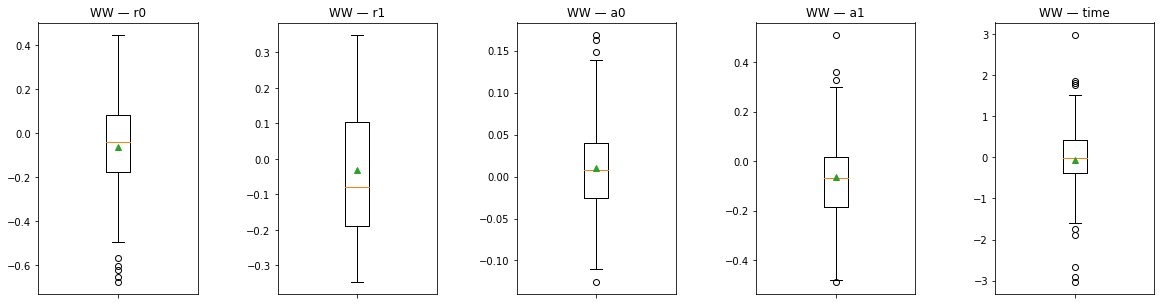

In [14]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        plot_errors_boxplot(inference_results, tip, scenario)       

### Errors swarmplots 


----------- Size is 674 -----------


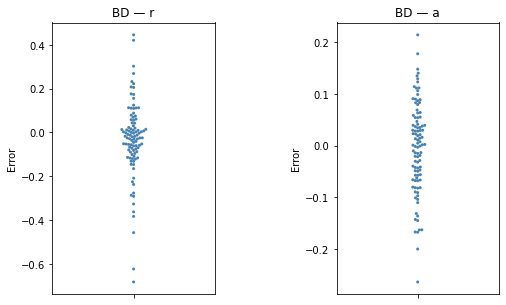

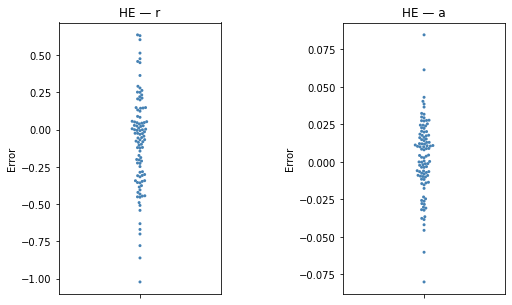

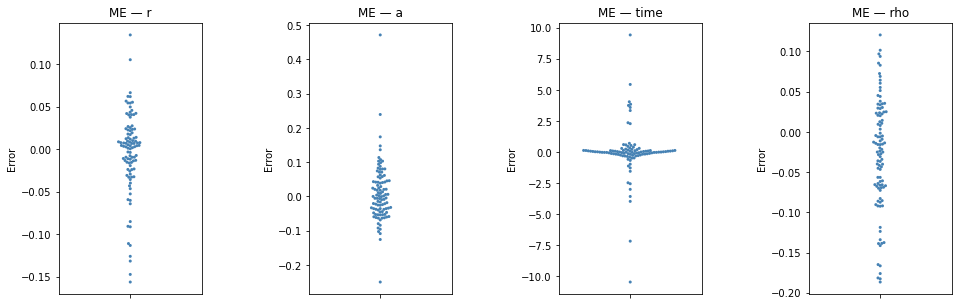

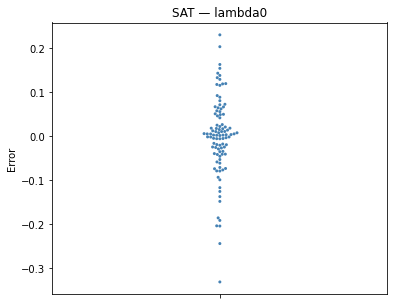

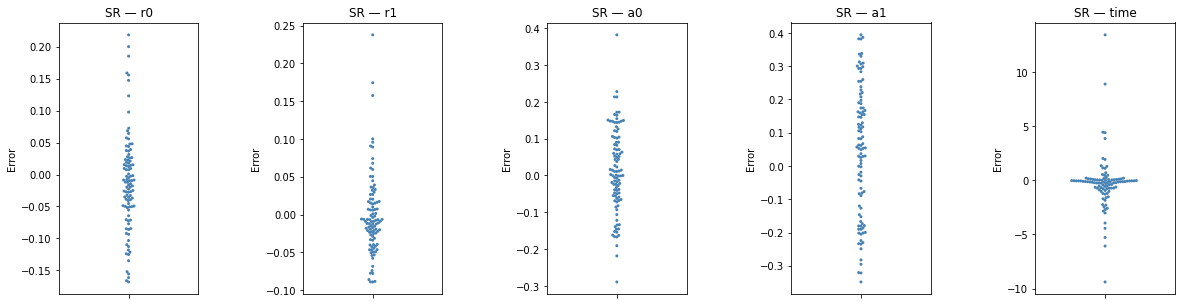

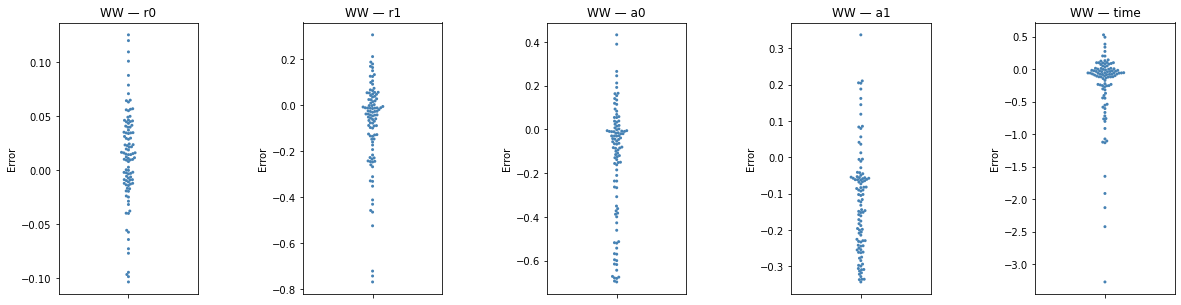


----------- Size is 489 -----------


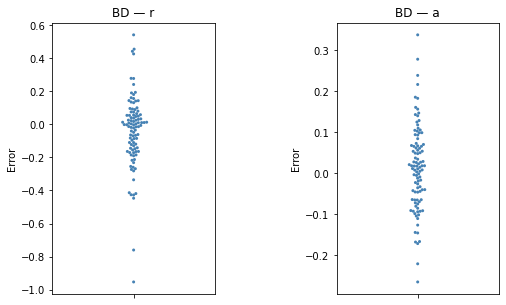

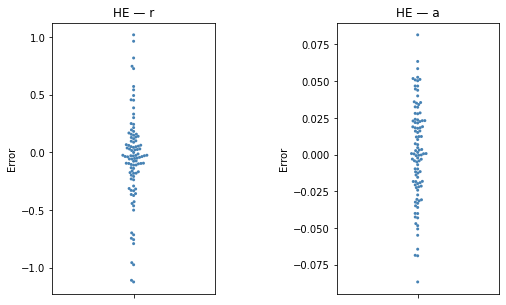

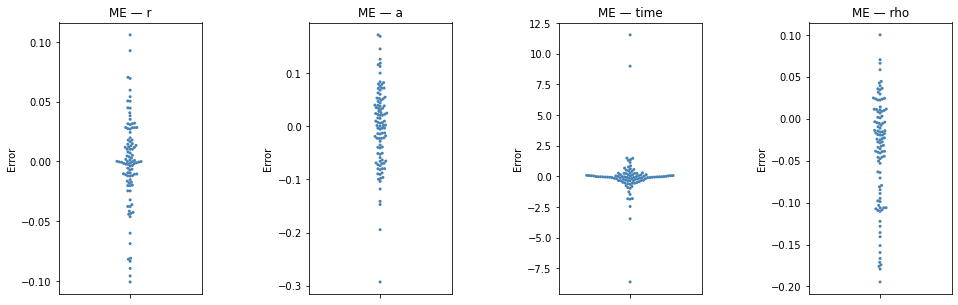

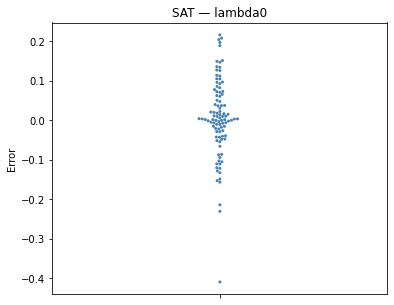

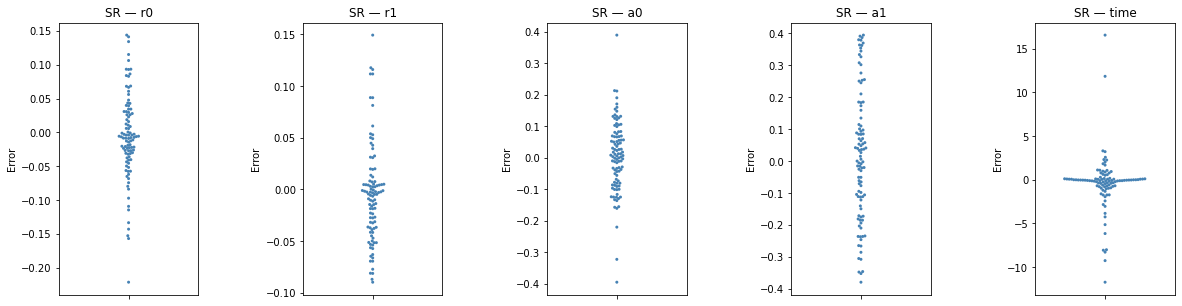

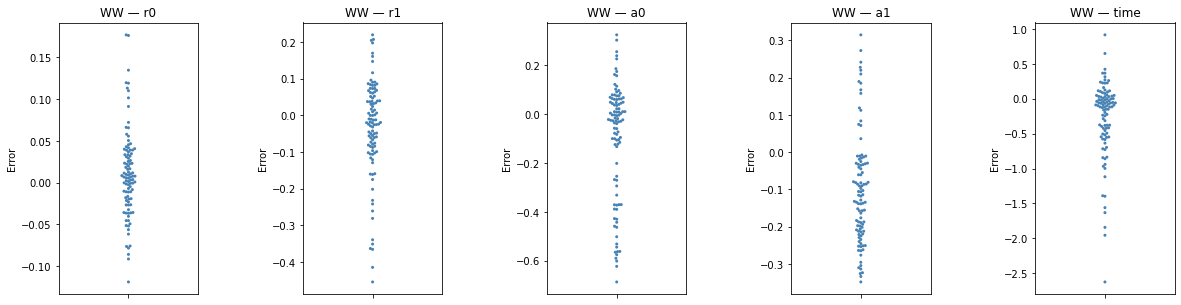


----------- Size is 87 -----------


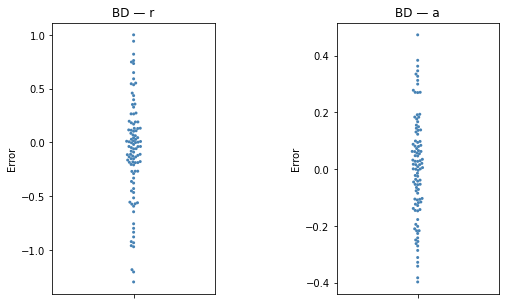

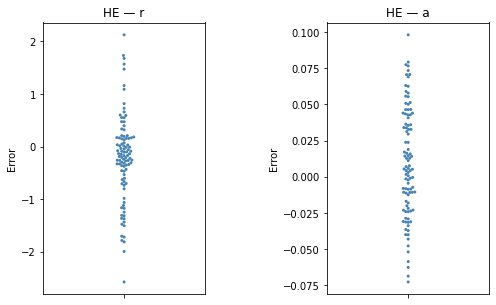

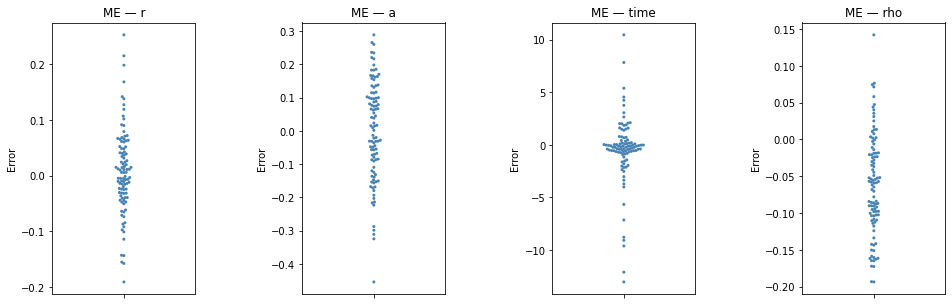

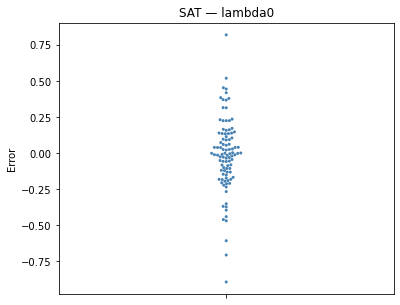

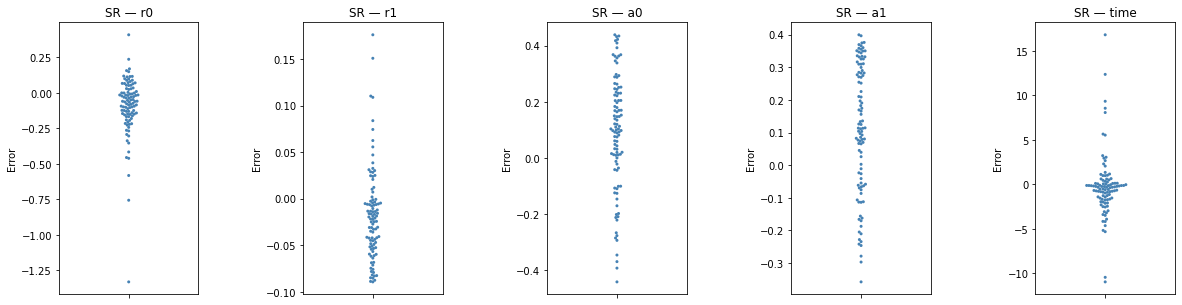

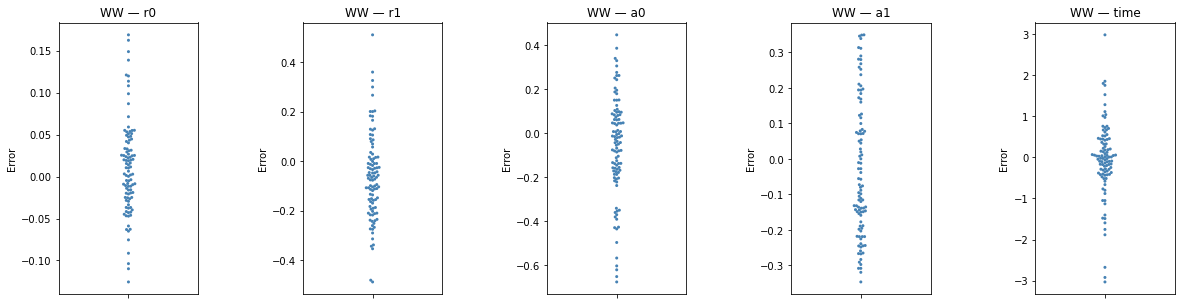

In [9]:
for tip in n_tips:
    print(f"\n----------- Size is {tip} -----------")
    for scenario in div_scenarios:
        plot_errors(inference_results, tip, scenario)      

### Absolute errors vs target

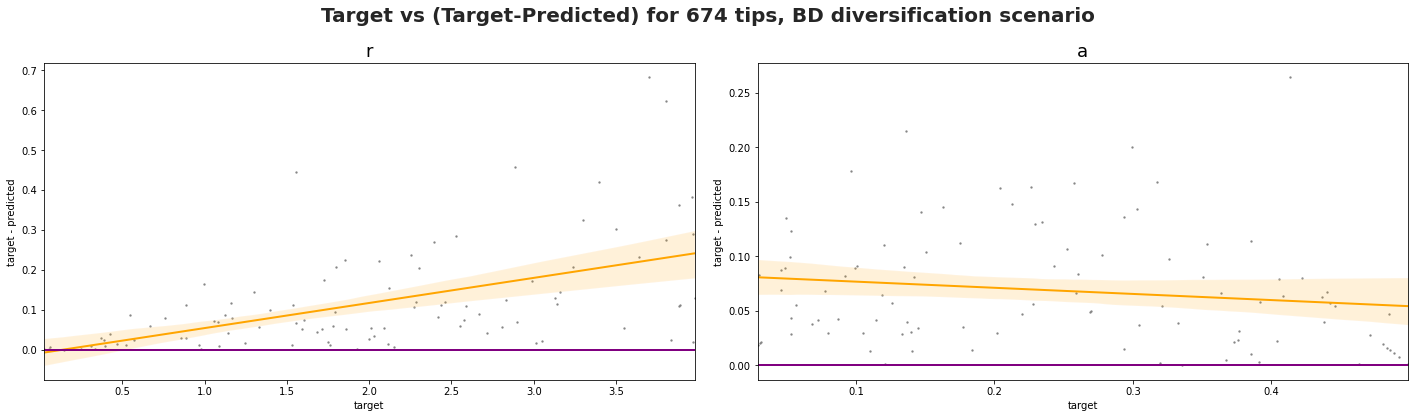

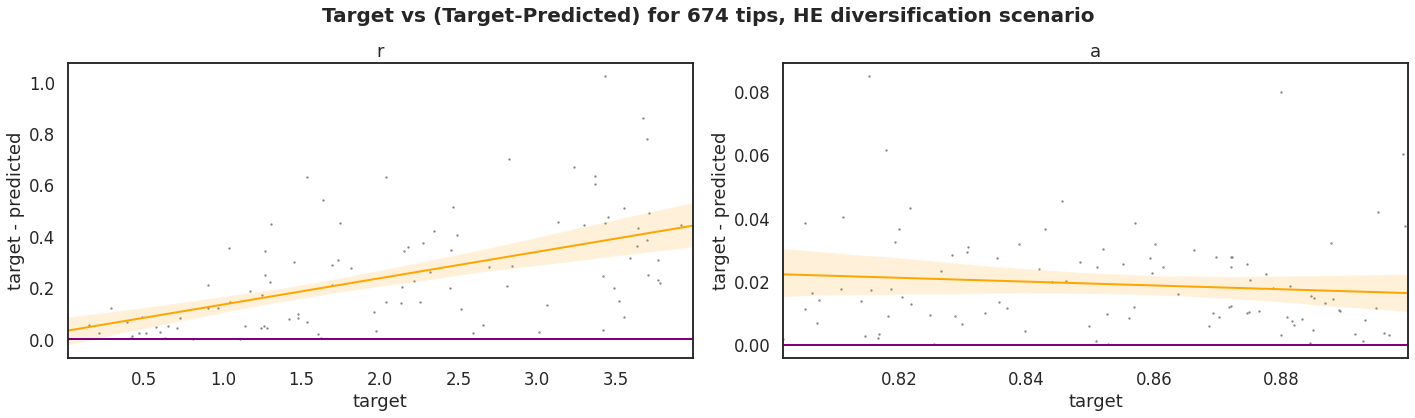

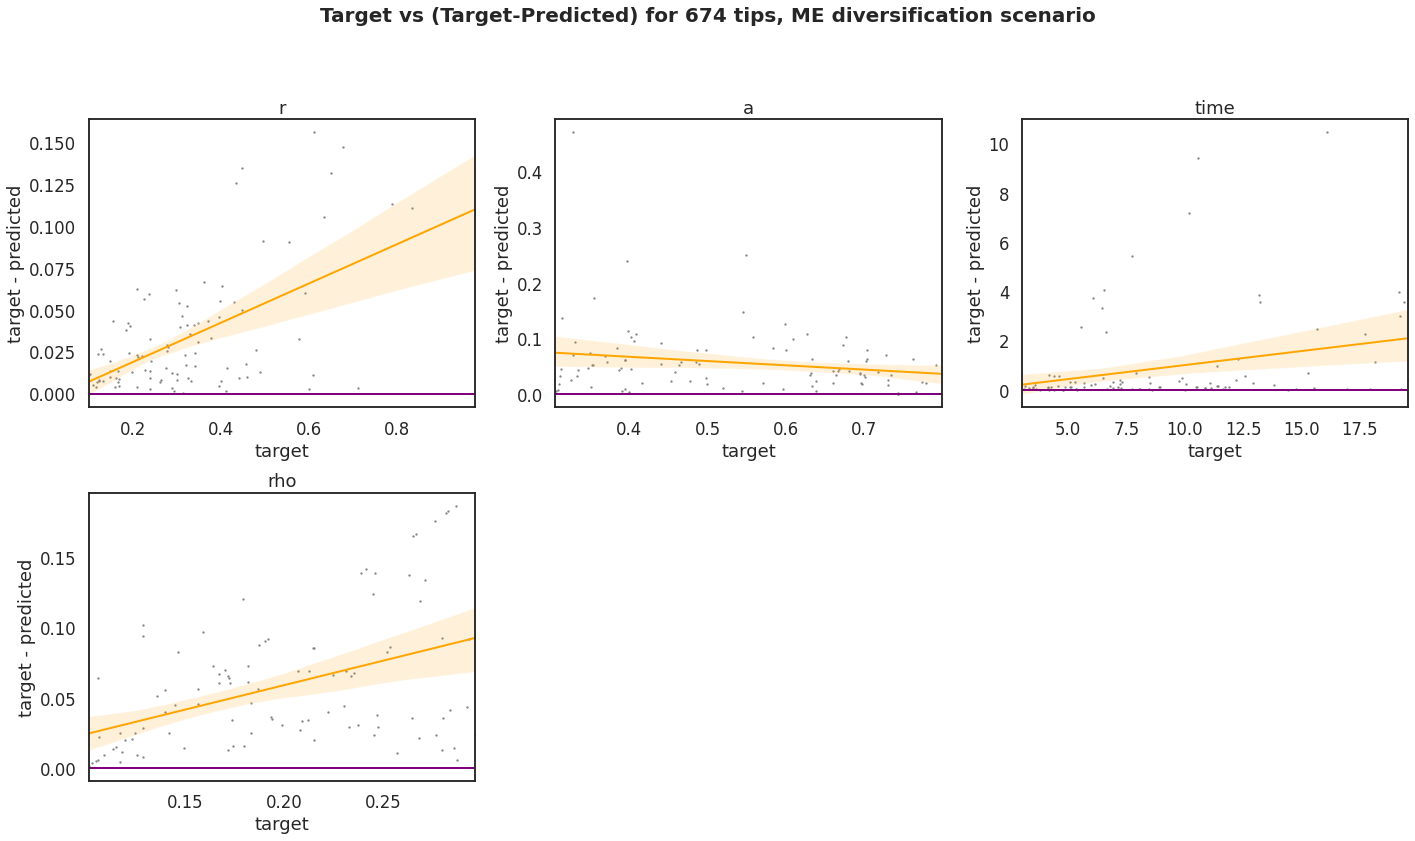

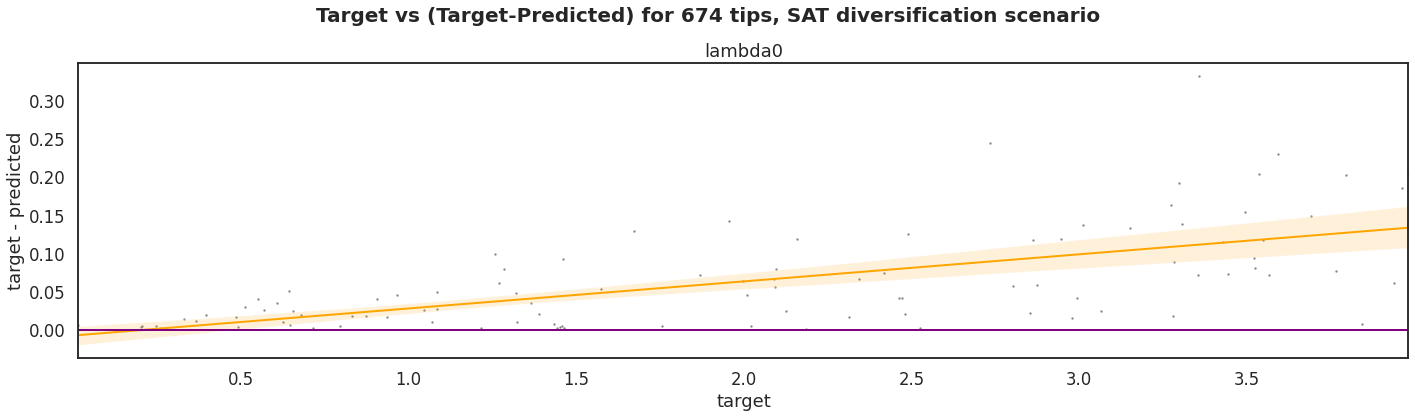

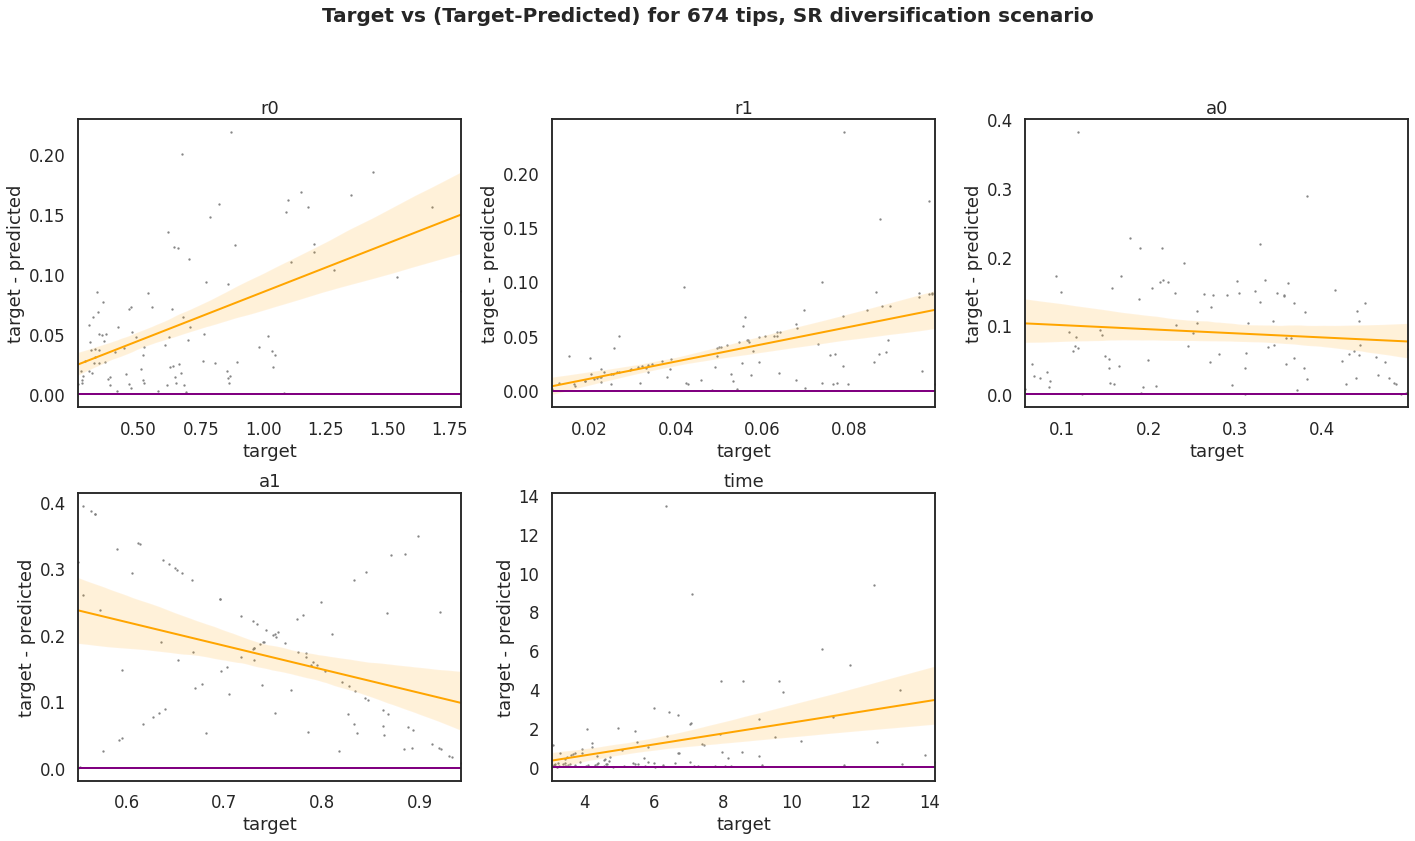

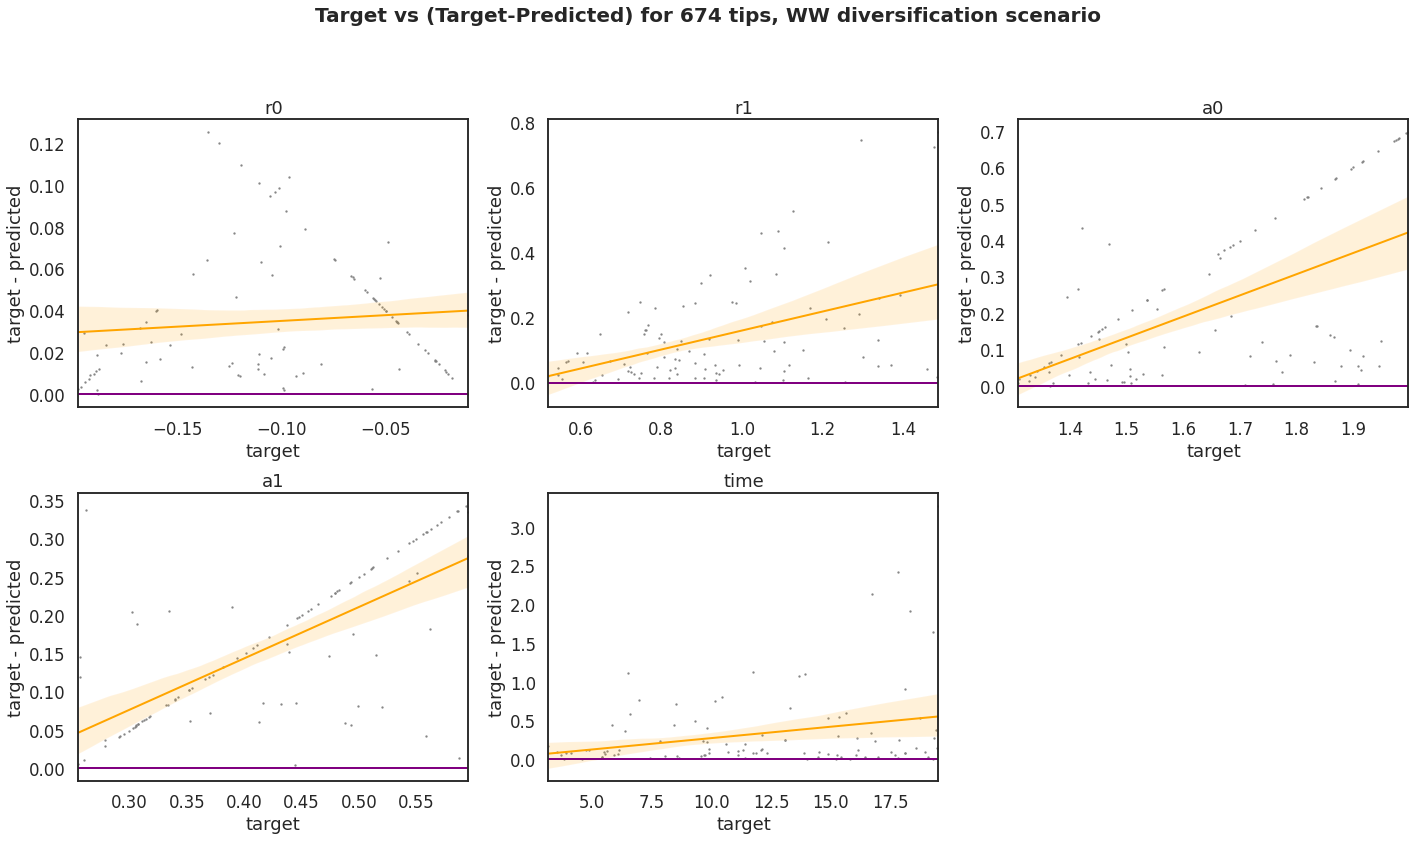

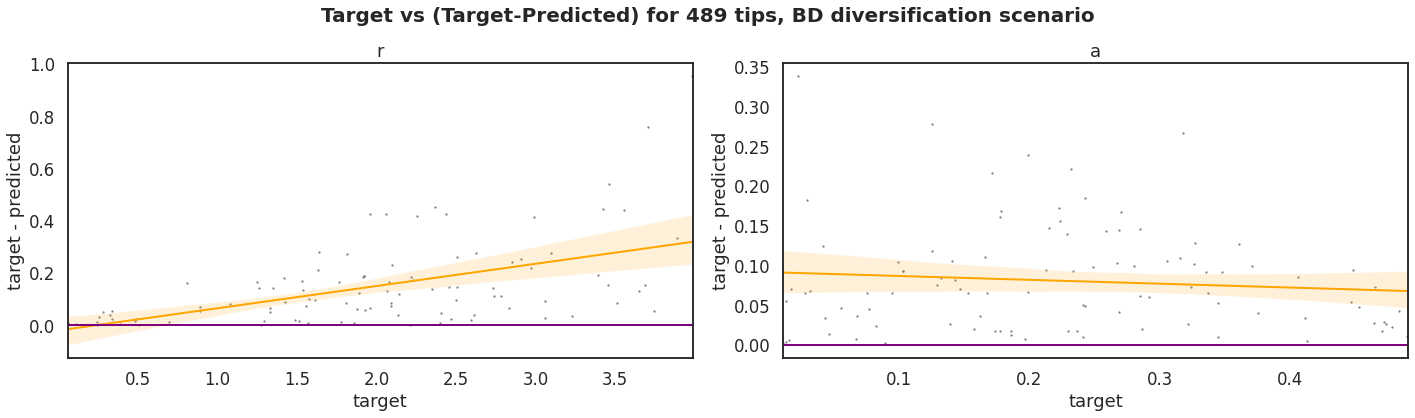

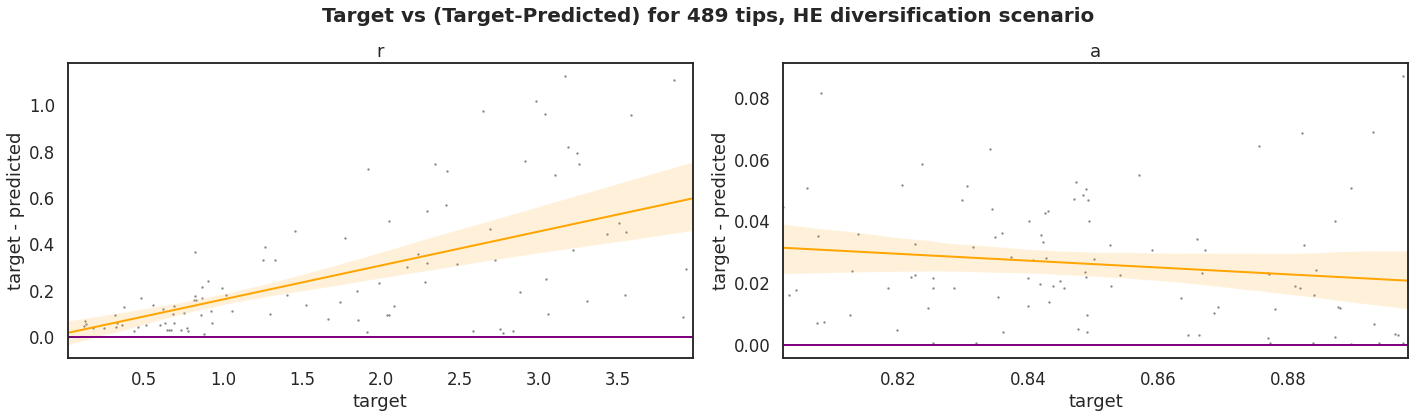

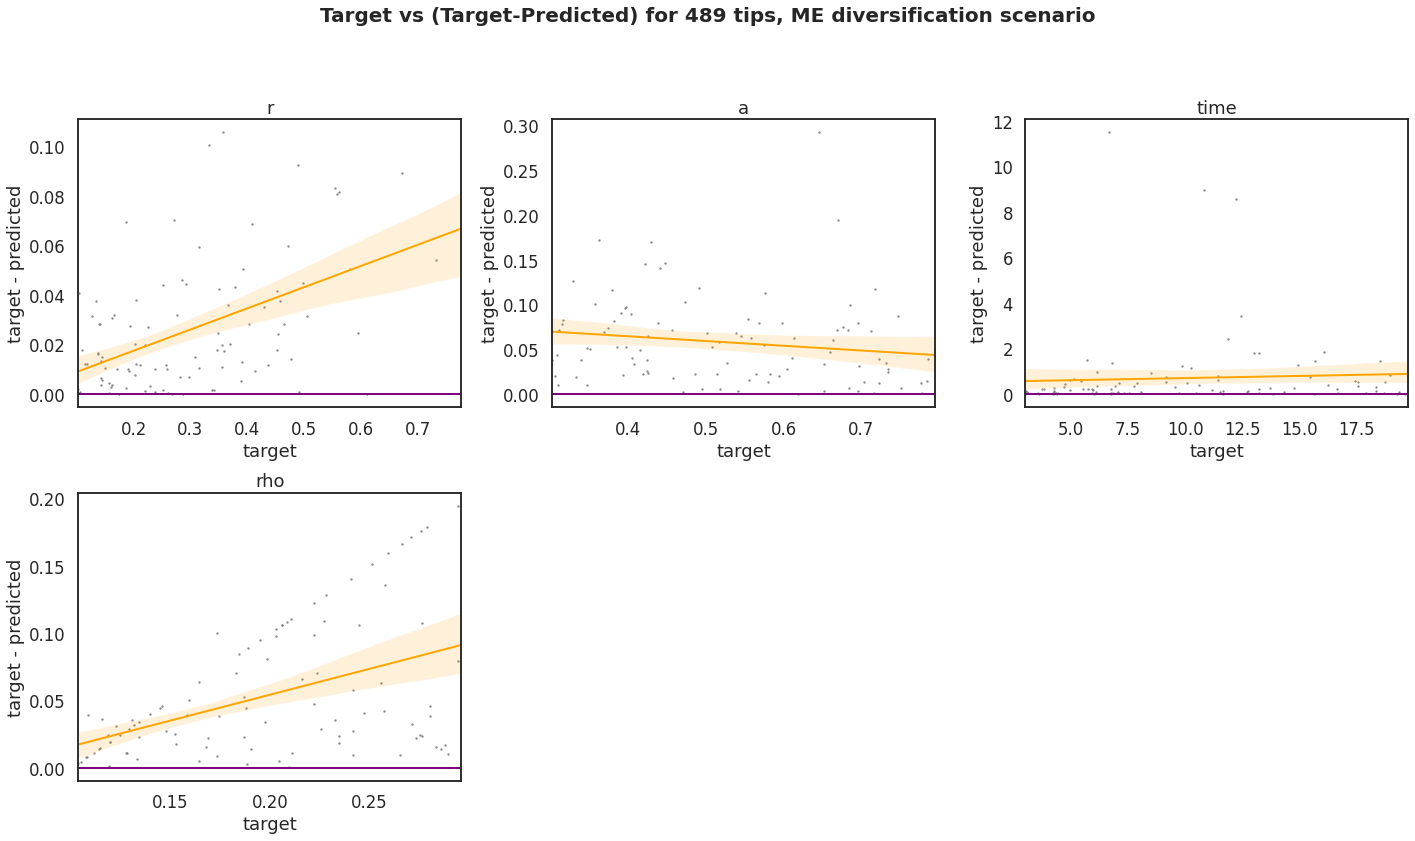

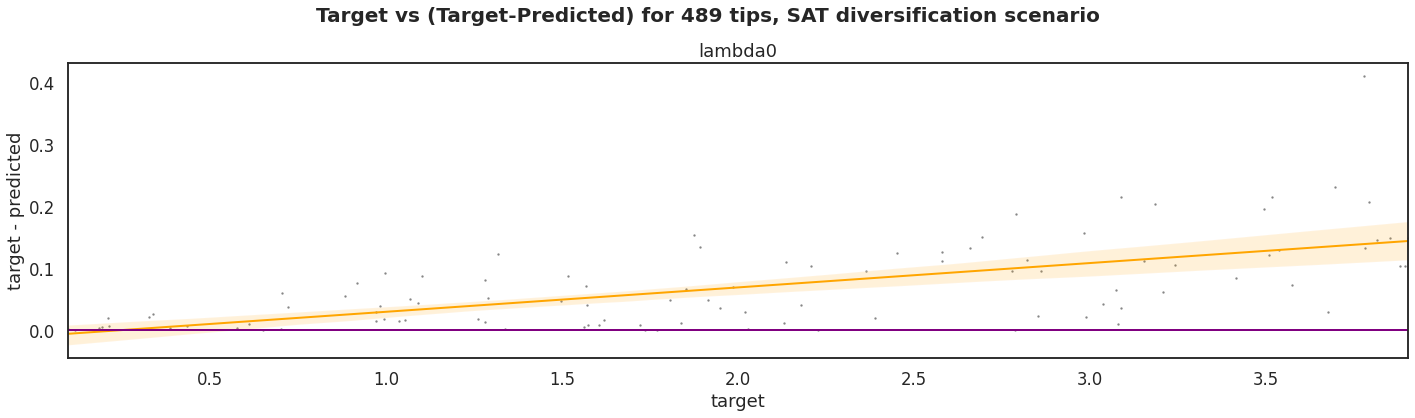

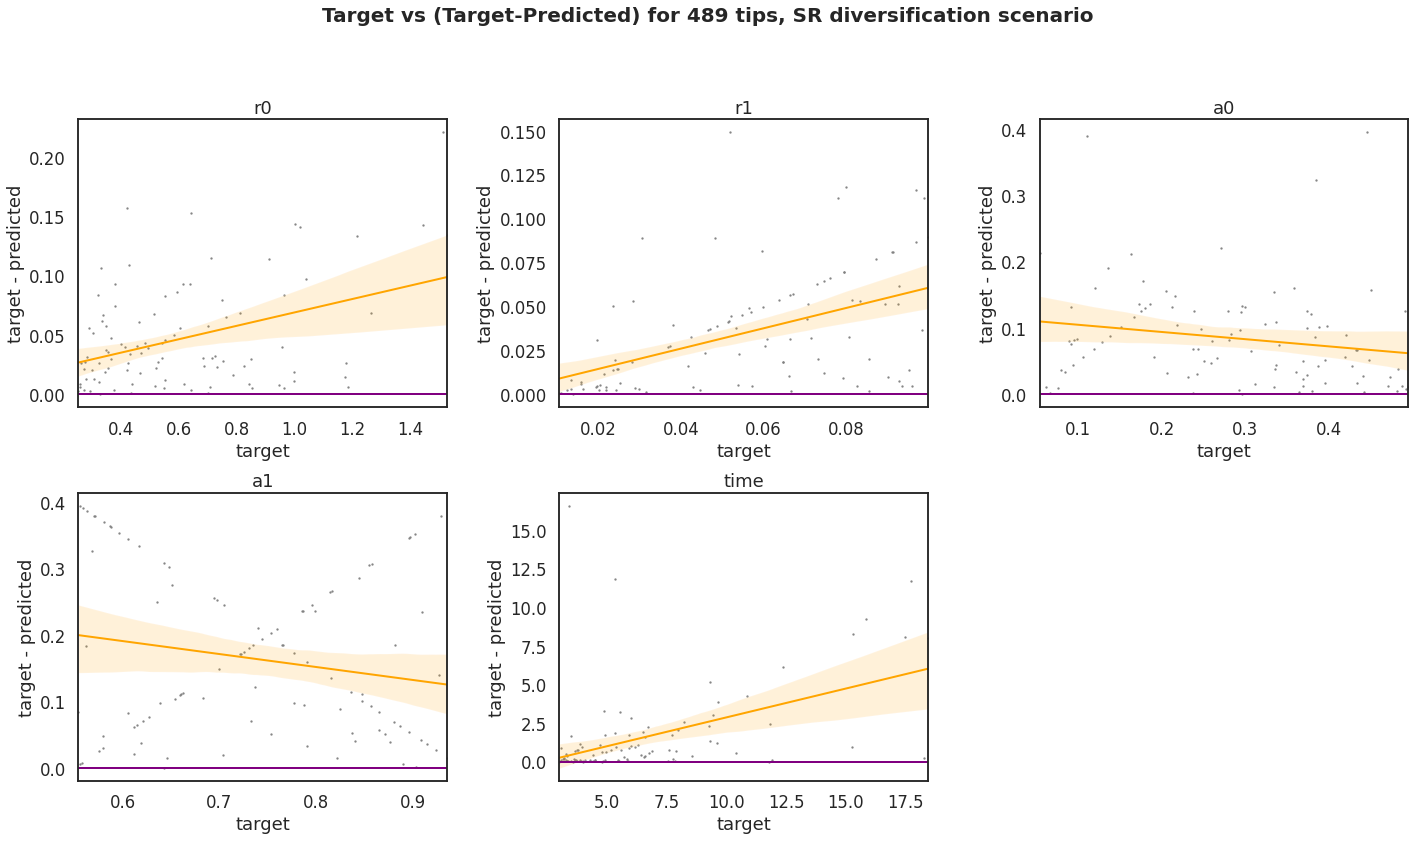

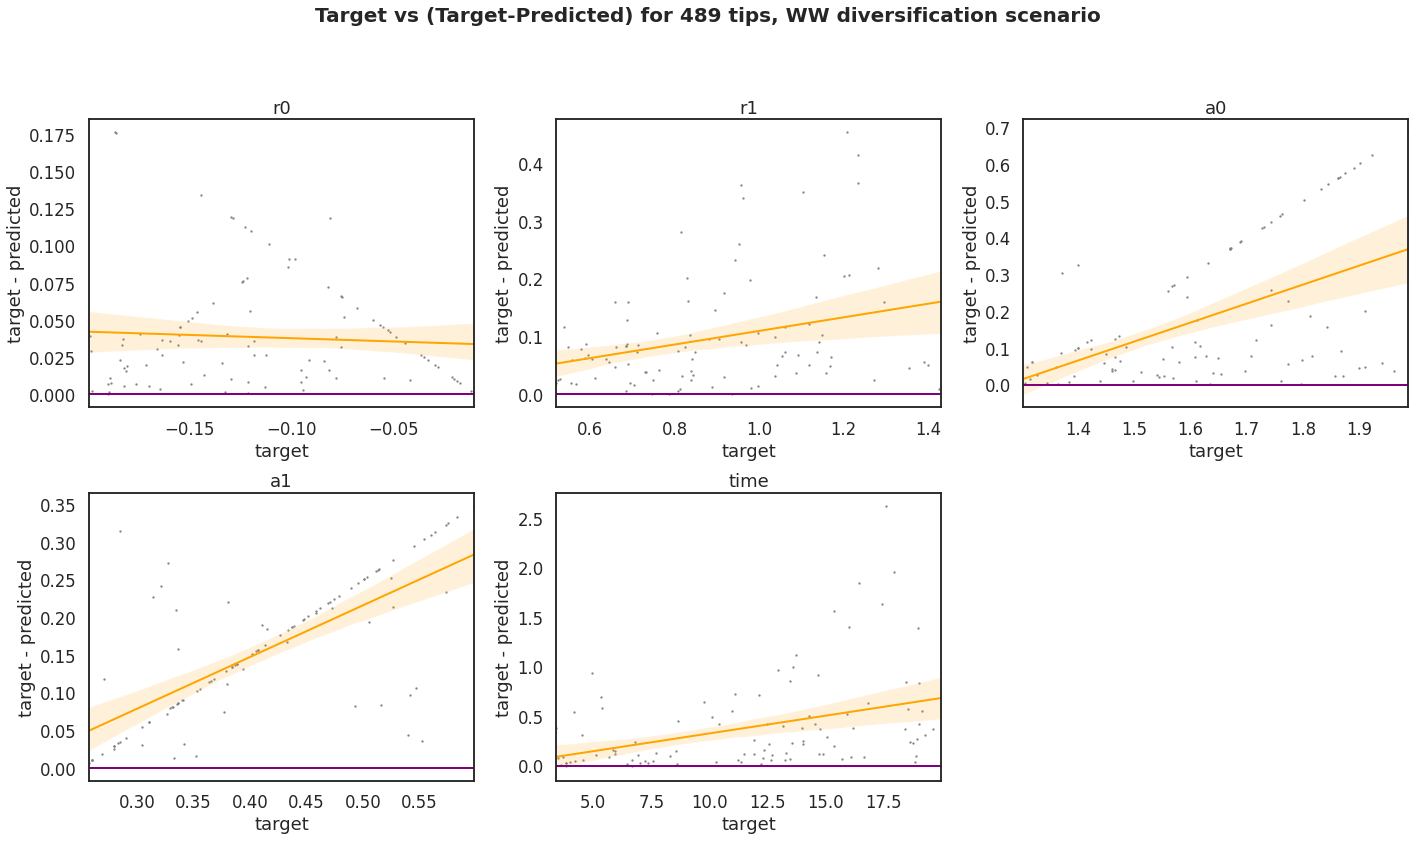

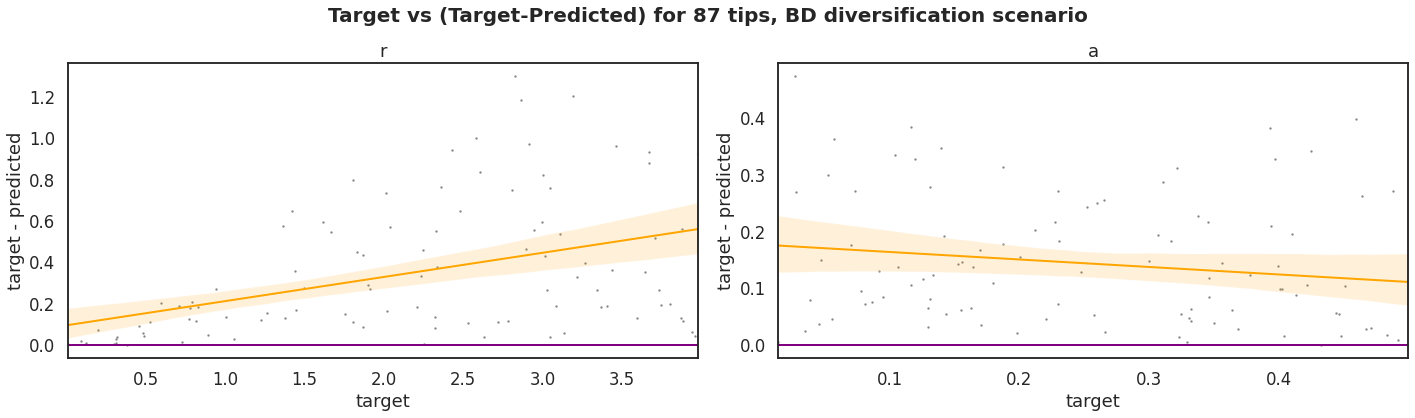

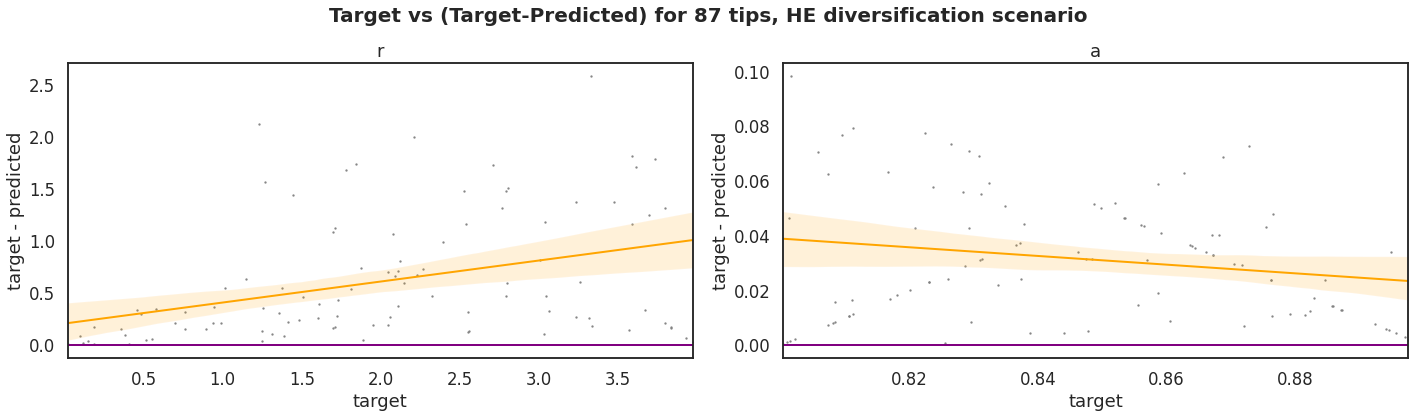

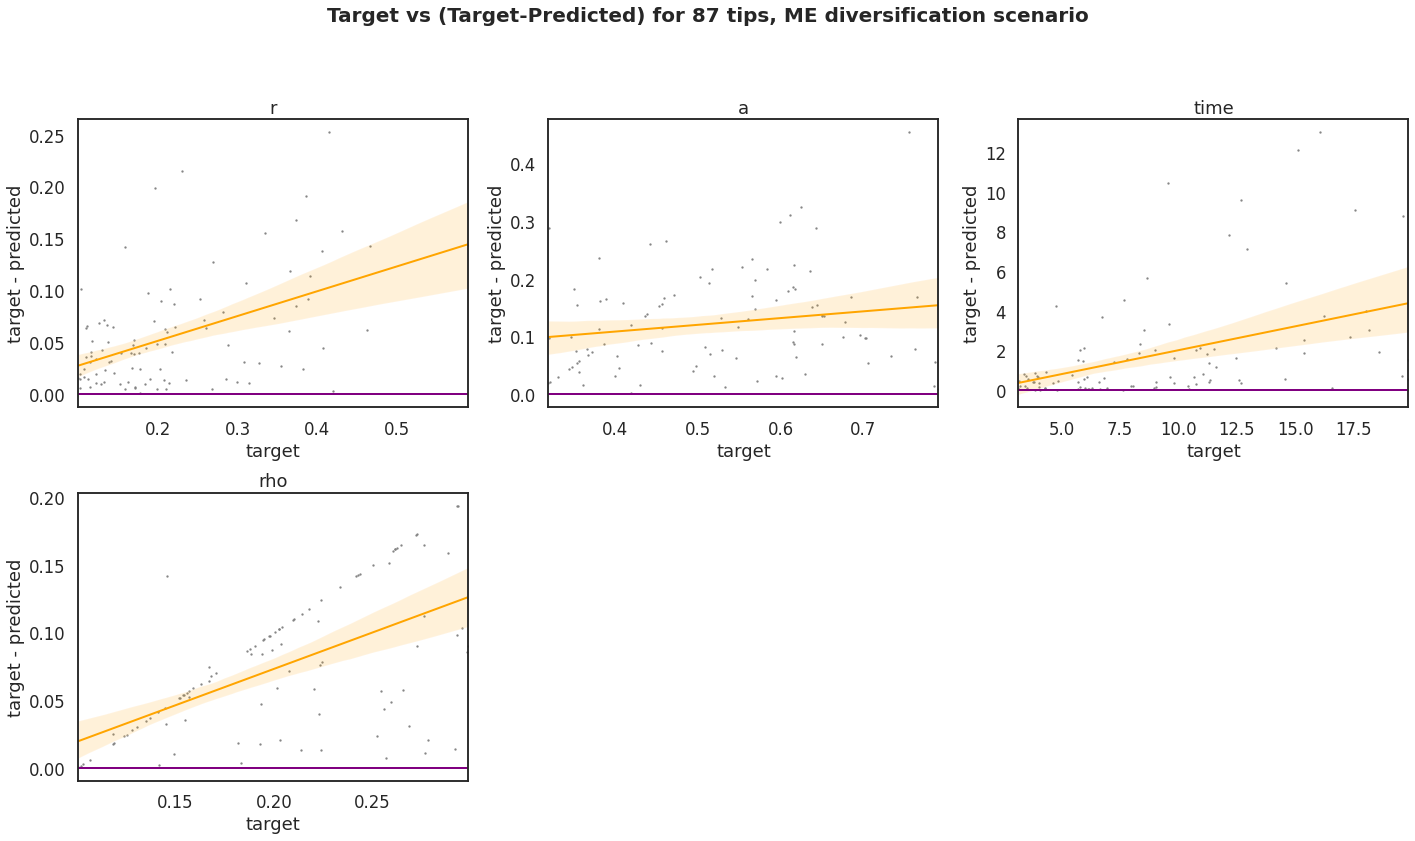

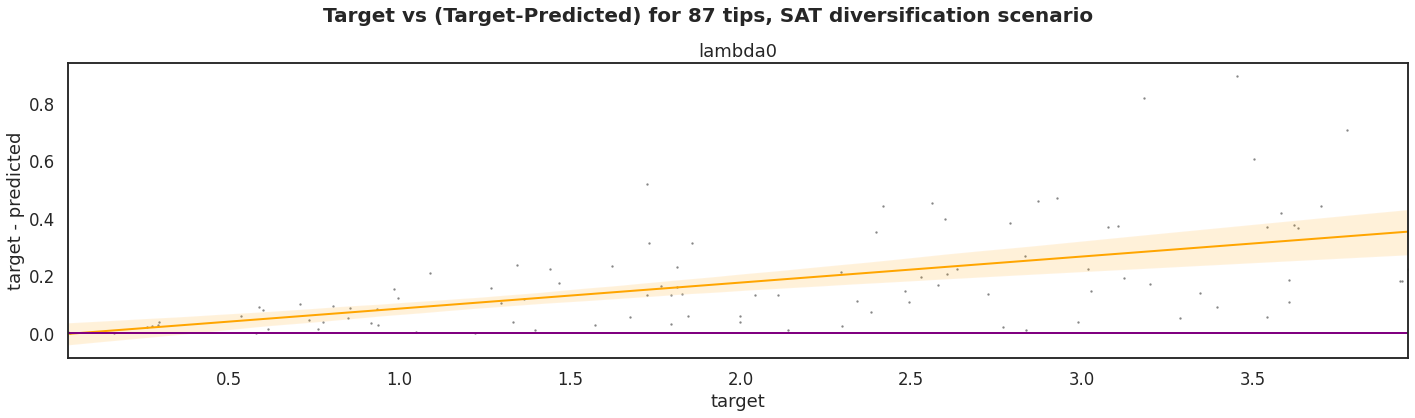

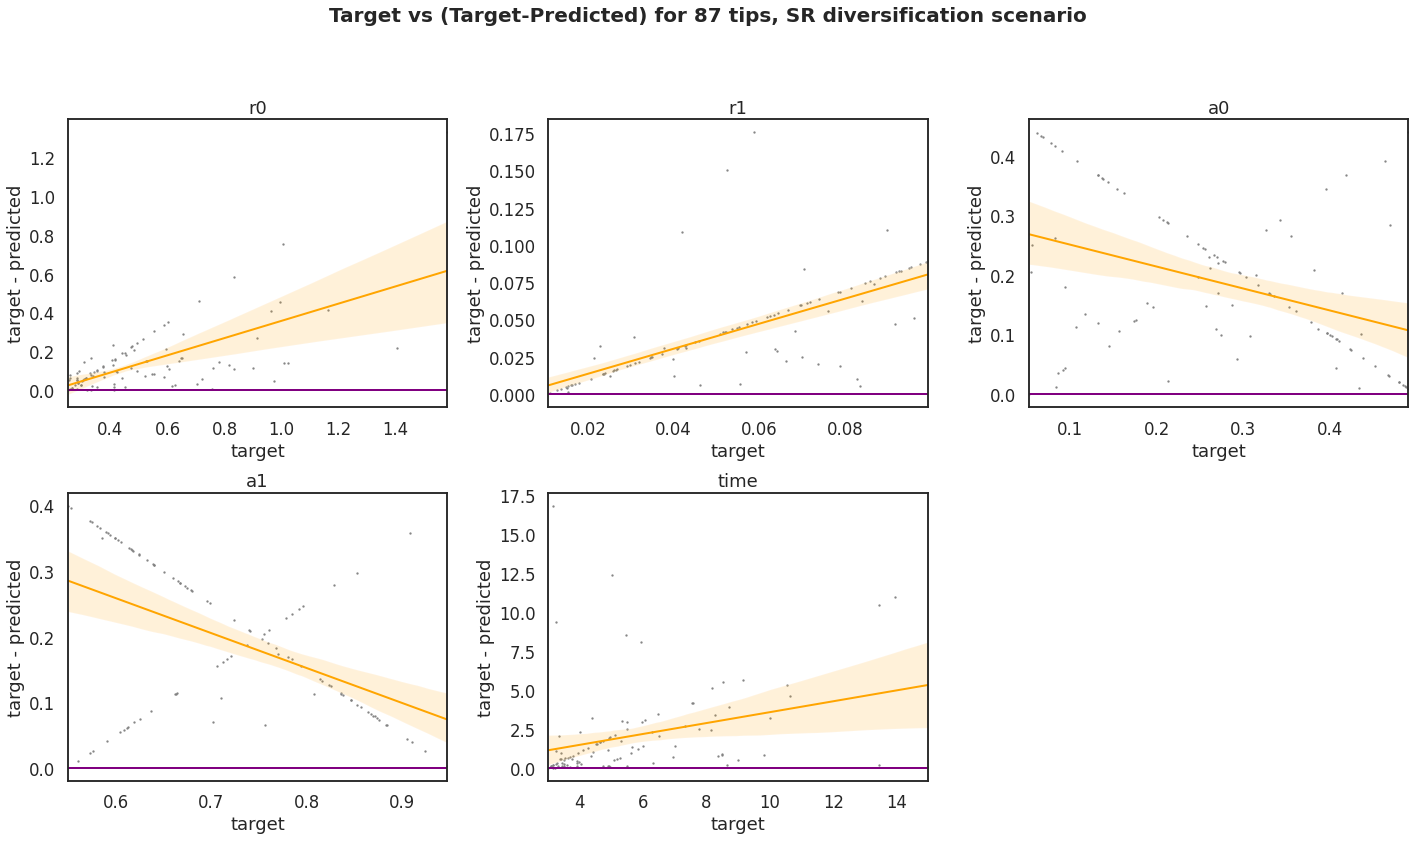

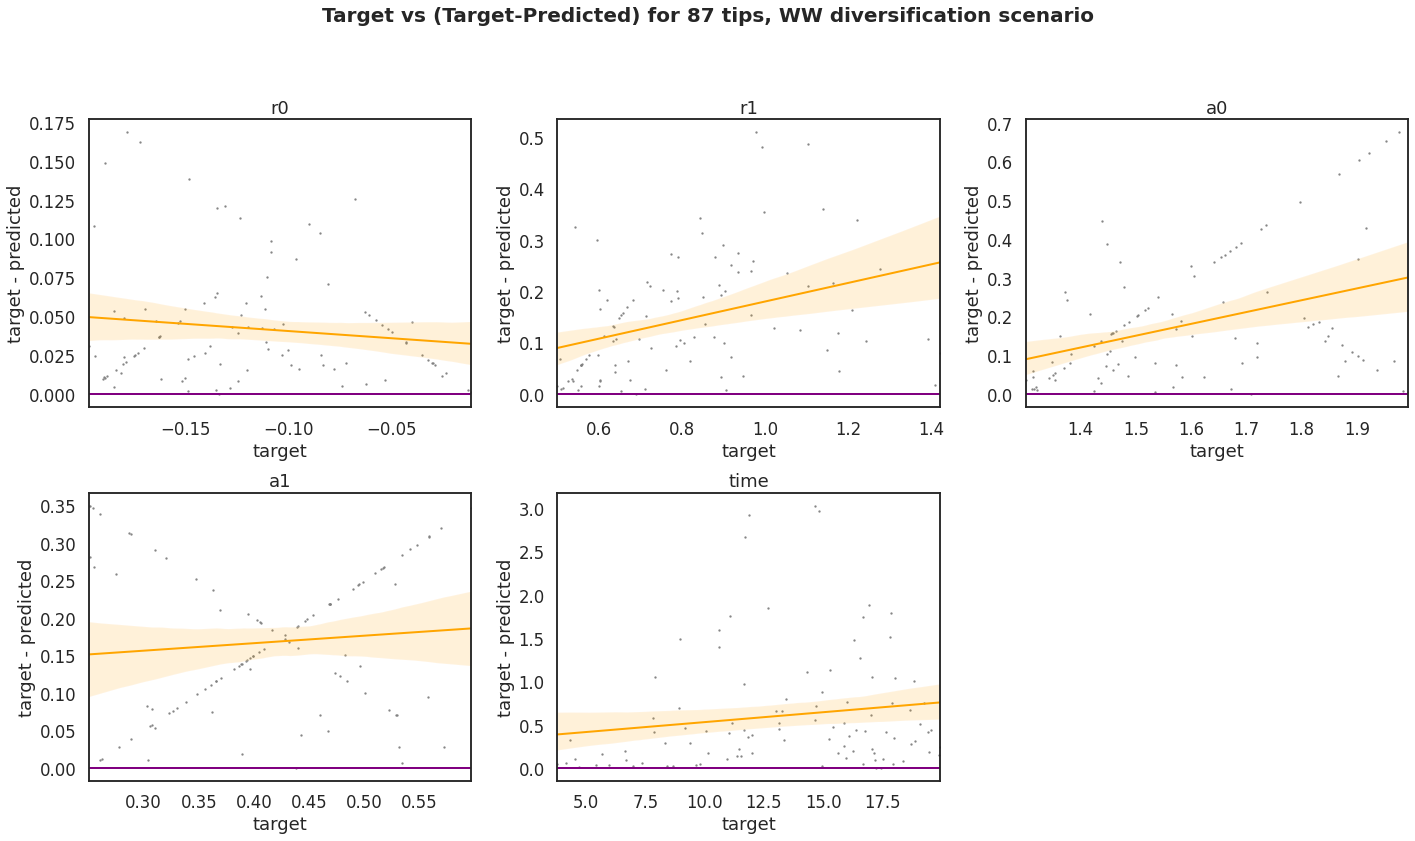

In [10]:
for tip in n_tips:
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(inference_results, tip, scenario)    